### Survival Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

#### Get the following datasets from running ```diabetes_surv_propens5.ipynb```

In [3]:
%%time
p = '../tempNN/'
treated0 = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

control0 = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)


CPU times: user 175 ms, sys: 106 ms, total: 281 ms
Wall time: 298 ms


In [4]:
data = [treated0,  control0]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [5]:
%%time
onset = 'IP-bin'
surv1 = treated0.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 2.28 s, sys: 8.06 ms, total: 2.29 s
Wall time: 2.29 s


In [6]:
%%time
surv3 = control0.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 9.18 s, sys: 11.6 ms, total: 9.19 s
Wall time: 9.19 s


In [7]:
%%time
#surv5 = random.groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


<div style="background:Aliceblue"> <h3>Fit Kaplan Meier Curves for Survival Analysis </br>
$P(T > t) = \prod_{t_i <t}\frac{n_i-d_i}{n_i}$ </br>
$n_i$: Remaining population before time $t_i$ </br>
$d_i$: Events (Diabetes Onsets) at time $t_i$
</h3>
</div>

In [8]:
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts



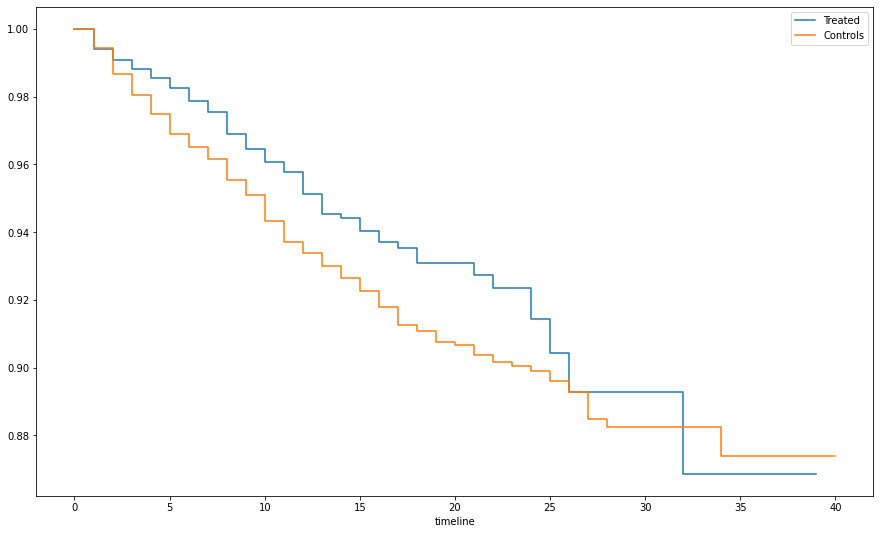

In [9]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf = KaplanMeierFitter()

kmf.fit(surv1['T'], event_observed=surv1.E, label="Treated")
kmf.plot_survival_function(ax=ax,ci_show=False)


kmf.fit(surv3['T'], event_observed=surv3.E, label="Controls")
kmf.plot_survival_function(ax=ax,ci_show=False)

#ax.set_xlim(0, 25)
#ax.set_ylim(0.94, 1)
fig.show()

In [10]:
results = logrank_test(surv1['T'], surv3['T'], event_observed_A=surv1.E, event_observed_B=surv3.E)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.68 0.03      5.04

### Cox Proportional Hazards Model: Models the hazard function $h(t|x)$  
$h(t|x) = h_0(t)f(x)$  
where $h_0$ is the baseline hazard function depending only on time $t$  
and $f(x)$ modifies the hazard function dependent on a subject's covariates

In [22]:
from sklearn.preprocessing import MinMaxScaler

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']

#columns_to_match = ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
#                  'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']
surv11 = surv1.loc[:,columns_to_match]
surv31 = surv3.loc[:,columns_to_match]

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']
surv11[columns_to_normalize] = MinMaxScaler().fit_transform(surv11[columns_to_normalize].values)
surv31[columns_to_normalize] = MinMaxScaler().fit_transform(surv31[columns_to_normalize].values)


cpx1 = CoxPHFitter().fit(surv11, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
cpx3 = CoxPHFitter().fit(surv31, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)


Iteration 1: norm_delta = 1.88036, step_size = 0.1000, log_lik = -563.33117, newton_decrement = 83.98906, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.67645, step_size = 0.1000, log_lik = -547.67489, newton_decrement = 28.38686, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.52565, step_size = 0.1000, log_lik = -542.30331, newton_decrement = 18.37353, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.42284, step_size = 0.1300, log_lik = -537.85436, newton_decrement = 11.70813, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.33788, step_size = 0.1690, log_lik = -534.24502, newton_decrement = 7.10658, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.26050, step_size = 0.2197, log_lik = -531.47466, newton_decrement = 3.95464, seconds_since_start = 0.0
Iteration 7: norm_delta = 0.18761, step_size = 0.2856, log_lik = -529.54324, newton_decrement = 1.91102, seconds_since_start = 0.0
Iteration 8: norm_delta = 0.12055, step_size = 0.3713, log_lik = -528.38933, ne

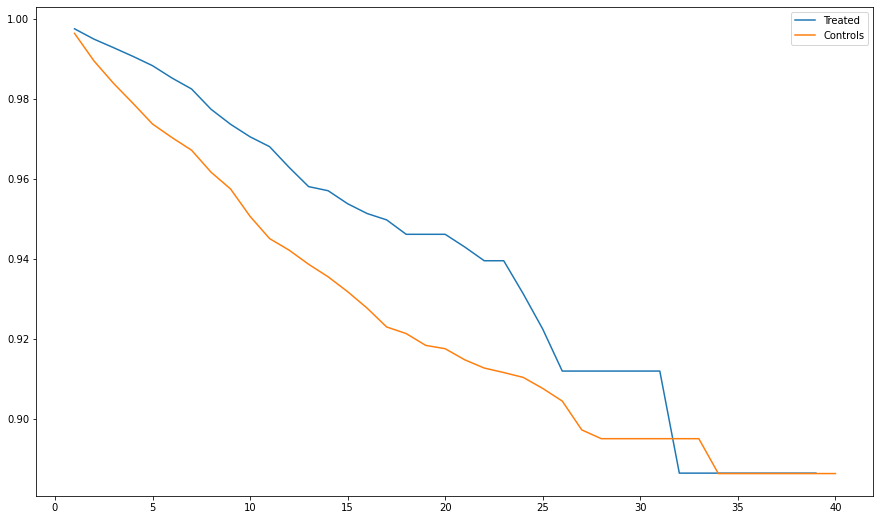

In [23]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpx1.baseline_survival_.plot(ax = ax)
cpx3.baseline_survival_.plot(ax = ax)
ax.legend(['Treated', 'Controls'])
plt.show()

### Coefficient Plot

### Treated

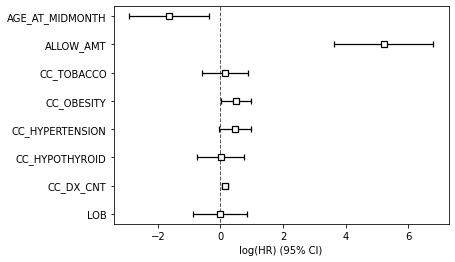

In [13]:
cols = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'LOB']
cpx1.plot(columns = cols)
plt.show()

### Controls

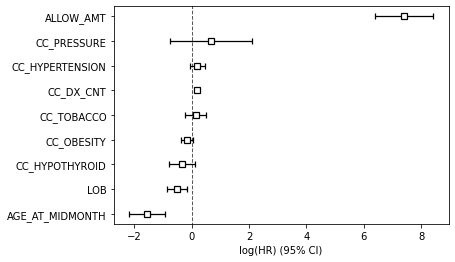

In [14]:
cpx3.plot()
plt.show()

## 1. Matched Controls plus Treated  
<h3><span style="color:red">to study the treatment effect</span></h3>

In [24]:
surv1['Treatment'] = 1

surv3['Treatment'] = 0

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'LOB', 'T', 'E', 'Treatment']

columns_to_match = ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']
columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

age_group = ['AGE_AT_MIDMONTH', 'T', 'E']
alltogether = pd.concat((surv1,  surv3), axis = 0, ignore_index = True )[columns_to_match]

cpxAge = CoxPHFitter().fit(alltogether[age_group], duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
alltogether[columns_to_normalize] = MinMaxScaler().fit_transform(alltogether[columns_to_normalize].values)

cpxAll = CoxPHFitter().fit(alltogether, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)


Iteration 1: norm_delta = 0.19962, step_size = 0.1000, log_lik = -4130.39450, newton_decrement = 9.15766, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.17886, step_size = 0.1000, log_lik = -4128.65467, newton_decrement = 7.38304, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.16037, step_size = 0.1000, log_lik = -4127.25198, newton_decrement = 5.95663, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.13894, step_size = 0.1300, log_lik = -4125.80406, newton_decrement = 4.48841, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.11495, step_size = 0.1690, log_lik = -4124.41535, newton_decrement = 3.08444, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.08929, step_size = 0.2197, log_lik = -4123.20912, newton_decrement = 1.86852, seconds_since_start = 0.0
Iteration 7: norm_delta = 0.06352, step_size = 0.2856, log_lik = -4122.29439, newton_decrement = 0.94887, seconds_since_start = 0.0
Iteration 8: norm_delta = 0.03978, step_size = 0.3713, log_lik = -4121.72072

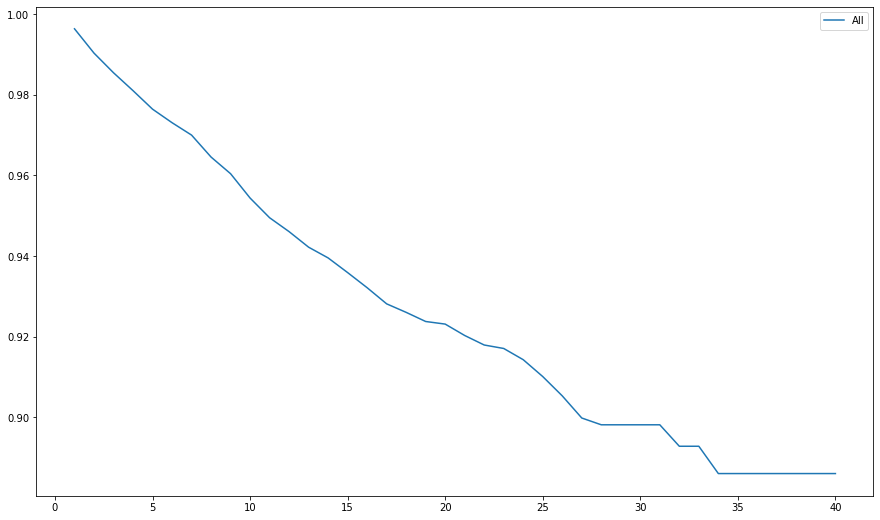

In [16]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpxAll.baseline_survival_.plot(ax = ax)
#cpxAge.baseline_survival_.plot(ax = ax)
ax.legend([ 'All'])
plt.show()

### All

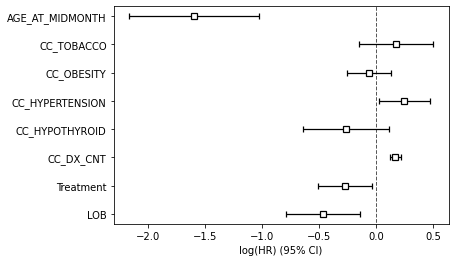

In [17]:
cols = ['AGE_AT_MIDMONTH', 'CC_TOBACCO', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'Treatment', 'LOB']
cpxAll.plot(columns = cols)
plt.show()

In [18]:
cpxAll.print_summary()

<lifelines.CoxPHFitter: fitted with 7682 total observations, 7195 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 7682
number of events observed = 487
   partial log-likelihood = -4017.32
         time fit was run = 2021-07-19 00:59:07 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
AGE_AT_MIDMONTH  -1.60       0.20       0.29            -2.17            -1.03                 0.11                 0.36
ALLOW_AMT         7.60    1997.76       0.47             6.67             8.53               787.88              5065.60
CC_TOBACCO        0.17       1.19       0.17            -0.15             0.50                 0.86                 1.65
CC_PRESSURE       0.44       1.55       0.72            -0.98             1.86                 0.38                 6.40
CC_OBESITY       -0.06       0.94       0.10            -0.25             0.13                 0.78                 1.14
CC_HYPERTENSION   0.25       1.28       0.11             0.02             0.47                 1.02                 1.60
CC_HYPOTHYROID   -0.27       0.76       0.19            -0.65             0.11                 0.52                 1.12
CC_DX_CNT         0.17       1.18       0.02             0.12             0.21                 1.12                 1.24
LOB              -0.47       0.63       0.17            -0.79            -0.14                 0.45                 0.87
Treatment        -0.27       0.76       0.12            -0.51            -0.04                 0.60                 0.97

                    z      p   -log2(p)
covariate                              
AGE_AT_MIDMONTH -5.49 <0.005      24.55
ALLOW_AMT       16.01 <0.005     189.20
CC_TOBACCO       1.04   0.30       1.74
CC_PRESSURE      0.61   0.54       0.88
CC_OBESITY      -0.62   0.53       0.91
CC_HYPERTENSION  2.15   0.03       5.00
CC_HYPOTHYROID  -1.39   0.16       2.60
CC_DX_CNT        6.73 <0.005      35.80
LOB             -2.82 <0.005       7.71
Treatment       -2.25   0.02       5.37
---
Concordance = 0.69
Partial AIC = 8054.65
log-likelihood ratio test = 226.14 on 10 df
-log2(p) of ll-ratio test = 140.38

### All

In [19]:
cpxAll.params_

covariate
AGE_AT_MIDMONTH   -1.599322
ALLOW_AMT          7.599784
CC_TOBACCO         0.173035
CC_PRESSURE        0.439049
CC_OBESITY        -0.061353
CC_HYPERTENSION    0.246422
CC_HYPOTHYROID    -0.268321
CC_DX_CNT          0.165929
LOB               -0.466124
Treatment         -0.272251
Name: coef, dtype: float64

In [20]:
import seaborn as sns

alltogether = pd.concat((surv1,  surv3), axis = 0, ignore_index = True )[columns_to_match]
bins = np.arange(10,115, 15)
ind = np.digitize(alltogether['AGE_AT_MIDMONTH'], bins)
data_new  = alltogether.copy()
data_new['ind'] = ind

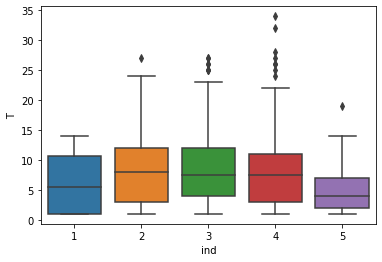

In [21]:
sns.boxplot(x = 'ind', y = 'T', data = data_new[data_new.E == 1])
plt.show()